# Debut

In [ ]:

from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
from functions.training import train_loop
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sbibm.metrics import c2st
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from functions.simulation import logratio_batch_z, logratio_z, NRE_posterior_pdf, NRE_corrected_posterior_pdf, find_grid_explorative, NRE_corrected_posterior_sample, NRE_posterior_sample
from functions.metrics import c2stest, evaluate_metrics, ranksumstest_stat, ranksumstest_pvalue
from functions.plots import plot_metric, plot_posterior_comparison
from functions.save import create_csv_for_a_dataset
import pandas as pd

@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return (jnp.mean(y) - jnp.mean(y_true))**2

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

def true_posterior_sample(key, TRUE_DATA, N_SAMPLE):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA))/(SIGMA0**2*len(TRUE_DATA) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(TRUE_DATA)/SIGMA**2)
    return random.normal(key, (N_SAMPLE,))*jnp.sqrt(sigma2_post)+ mu_post


def true_posterior_pdf(theta, TRUE_DATA):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA))/(SIGMA0**2*len(TRUE_DATA) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(TRUE_DATA)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = jnp.sqrt(sigma2_post)).pdf(theta)

    

def true_ratio_z(mus, z, prior, posterior):
    return posterior(z).pdf(mus)/prior.pdf(mus)

def true_decision_z(mus, z, prior, posterior):
    return 1/(1+1/true_ratio_z(mus, z, prior, posterior))

def true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior):
    pseudo = true_pseudo_post(mus, bar_xobs, epsilon, prior)
    Z_pseudo = np.trapz(pseudo, mus)
    return posterior(z).pdf(mus)/pseudo*Z_pseudo

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def true_pseudo_post(mus, bar_xobs, epsilon, prior):
    return prior.pdf(mus)*(norm.cdf(bar_xobs+np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)) - norm.cdf(bar_xobs-np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)))

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def decision_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_z(params, mus, z)))
def decision_batch_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_batch_z(params, mus, z)))

def ABC_gauss_single(key, true_data, epsilon):
    key, key_xbar = random.split(key)
    xbar = random.truncated_normal(key_xbar, lower = (jnp.mean(true_data)-jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)), upper = (jnp.mean(true_data)+jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)))*jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)) + MU0
    dist = (jnp.mean(true_data)-xbar)**2
    key, key_z = random.split(key)
    z = random.normal(key_z, (len(true_data),))*SIGMA
    z = z-jnp.mean(z)+xbar
    key, key_mu = random.split(key)
    mu = random.normal(key_mu, (1,))*SIGMA/jnp.sqrt(len(true_data)) + xbar
    return z, mu, dist


def ABC_gauss(key, true_data, epsilon, N_ABC):
    keys = random.split(key, N_ABC+1)
    zs, mus, dists = vmap(jit(ABC_gauss_single), (0, None, None))(keys[1:], true_data, epsilon)
    return zs, mus, dists, keys[0]

def get_epsilon_star_gauss(key, acceptance_rate, n_points, prior_simulator, data_simulator, discrepancy, true_data, quantile_rate = .9, epsilon = jnp.inf, return_accept = False):
    new_epsilon = epsilon
    accept = 1.
    
    datas, thetas, dists, key = ABC_gauss(key, true_data, epsilon, n_points)
    if epsilon == jnp.inf:
        print("Distances: min = ", jnp.min(dists), "max = ", jnp.max(dists), "mean = ", jnp.mean(dists), "std = ", jnp.std(dists))
    while accept > acceptance_rate:
        epsilon = new_epsilon
        new_epsilon = float(jnp.quantile(dists, quantile_rate))
        datas, thetas, dists, key = ABC_gauss(key, true_data, new_epsilon, n_points)
        key, subkey = random.split(key)
        keys_pred = random.split(subkey, n_points)
        datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, thetas)
        new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, true_data)
        accept = jnp.mean(new_dists < new_epsilon)
        epsilon = new_epsilon
        print("epsilon: ", epsilon, "acceptance rate: ", accept)
    if return_accept: 
        return epsilon, accept, key
    return epsilon, key

def get_dataset_gauss(key, n_points, prior_simulator, data_simulator, discrepancy, epsilon, true_data):
    n_points = n_points//2
    zs, thetas, _, key = ABC_gauss(key, true_data, epsilon, n_points)
    key, key_perm = random.split(key)
    thetas_prime = thetas[random.permutation(key_perm, jnp.arange(n_points))]
    zs = jnp.concatenate([zs, zs], axis=0)
    thetas = jnp.concatenate([thetas, thetas_prime], axis=0)
    ys = jnp.append(jnp.zeros(n_points), jnp.ones(n_points)).astype(int)
    Xs = jnp.concatenate([thetas, zs], axis=1)
    return Xs, ys, key


The standard NRE output is the ratio:
$$\hat r(x\mid \theta) \approx r(x\mid \theta) = \frac{f(x\mid\theta)}{p(x)} = \frac{\pi(\theta\mid x)}{\pi(\theta)}$$

The posterior approximation is then 
$$\hat \pi(\theta\mid x) \propto \pi(\theta) \cdot\hat r(x\mid \theta)$$

Here we train the NRE classifier with datas from the ABC joint pseudo posterior $\pi_\epsilon(\theta,x\mid x_o)$ with $\epsilon \in ] 0 , + \infty [$.

The ABC-NRE output is then:
$$\hat r_\epsilon(x\mid \theta, x_o) \approx r_\epsilon(x\mid \theta, x_o) =  \frac{\pi(\theta\mid x)}{\pi_\epsilon(\theta\mid x_o)}$$

and the posterior approximation becomes : 

$$\hat \pi(\theta\mid x, x_o) \propto \hat \pi_\epsilon(\theta\mid x_o) \cdot \hat r_\epsilon(x\mid \theta, x_o)$$

where $ \hat \pi_\epsilon(\theta\mid x_o) $ is a KDE approximation of the ABC pseudo posterior that plays the role of the ABC correction. 


Here we compare: 
- the ABC-NRE approximation with the KDE correction: $\hat \pi(\theta\mid x, x_o) \propto \hat \pi_\epsilon(\theta\mid x_o) \cdot \hat r_\epsilon(x\mid \theta, x_o)$.
- the ABC-NRE approximation without the KDE correction: $\hat \pi(\theta\mid x, x_o) \propto \pi(\theta) \cdot r_\epsilon(x\mid \theta, x_o)$. 
- the ABC pseudo posterior: $\pi_\epsilon(\theta\mid x_o)$
- the true posterior: $\pi(\theta\mid x_o)$.

Here we consider the Gaussian toy model 
$$\mu \sim \mathcal N(0, 10^2) \quad x = (x_1, \cdots, x_n) \sim \mathcal N(\mu, 1)$$

Even with $n = 10$, we remark that $r_\epsilon (x \mid \theta, x_o) >> \pi_\epsilon(\theta\mid x_o) \approx \pi(\theta)$ so there is no the correction does not change the posterior approximation. 

When $\epsilon$ is too small, $r_\epsilon(x\mid \theta, x_o) \propto 1$ and $\pi_\epsilon(\theta\mid x_o) \approx \pi(\theta\mid x_o)$. The NRE approximation without the correction is then the prior and becomes close to the posterior with the ABC correction. 


# Data simulation ($x_o$)

In [3]:
key = random.PRNGKey(0)
SIGMA0 = 20.
MU0 = 0.
SIGMA = 1.
TRUE_MU = 2.*SIGMA0
N_DATA = 5
MODEL_ARGS = [SIGMA]
PRIOR_ARGS = [MU0, SIGMA0]

key, subkey = random.split(key)
TRUE_DATA = random.normal(subkey, (N_DATA,))*SIGMA + TRUE_MU

PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
MIN_INIT, MAX_INIT = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)
N_EPSILON = 1000000
zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, np.inf, N_EPSILON)
ALPHAS = [.99,.9, .75,.5,.25, .1,.05, .01, .005, .001, .0005,.0001]
EPSILONS = {1.: jnp.inf}
for alpha in ALPHAS: 
    EPSILONS[alpha] = jnp.quantile(dists, alpha)

ALPHAS = [1.]+ALPHAS

# Training loop

In [ ]:
key = random.PRNGKey(0)

N_KDE = 10000
N_POINTS = 1000000
N_POINTS_EPS = 100000
N_SAMPLE = 10000
N_SAMPLES = 1


N_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID = 10000

NN_ARGS = {
    "N_EPOCH": N_EPOCHS,
    "NUM_LAYERS": NUM_LAYERS,
    "HIDDEN_SIZE": HIDDEN_SIZE,
    "BATCH_SIZE": BATCH_SIZE,
    "NUM_BATCH": NUM_BATCH,
    "LEARNING_RATE": LEARNING_RATE,
    "WDECAY": WDECAY,
    "PATIENCE": PATIENCE,
    "COOLDOWN": COOLDOWN,
    "FACTOR": FACTOR,
    "RTOL": RTOL,
    "ACCUMULATION_SIZE": ACCUMULATION_SIZE,
    "LEARNING_RATE_MIN": LEARNING_RATE_MIN
}

METRICS_TO_TEST = = {"C2ST": c2stest, "RS_stat": ranksumstest_stat, "RS_pvalue": ranksumstest_pvalue}

METRICS = {}
PARAMS = {}
TRAIN_ACCURACY = {}
TEST_ACCURACY = {}
TIME_TRAINING = {}
TIME_SIM = {}
TIME_METRICS = {}
THETAS_ABC = {}
for alpha in tqdm(ALPHAS):
    EPSILON_STAR = EPSILONS[alpha]
    print(f"----------------------\nALPHA = {alpha} EPSILON = {EPSILON_STAR:.2}\n----------------------")


    print("Simulations of the dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X, y, key = get_dataset_gauss(subkey, N_POINTS, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    time_sim = time.time()-time_sim
    
    thetas_abc = X[:N_KDE, 0]
    print('Time to simulate the dataset: {:.2f}s\n'.format(time_sim))
    N_POINTS_TRAIN, N_POINTS_TEST = X_train.shape[0], X_test.shape[0]

    print("Training the neural network...")
    time_nre = time.time()
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, NN_ARGS, prior_simulator, data_simulator, discrepancy, TRUE_DATA, X_train, y_train, X_test, y_test, N_POINTS_TRAIN, N_POINTS_TEST, EPSILON_STAR)
    time_nre = time.time()-time_nre
    print('Time to train the neural network: {:.2f}s\n'.format(time_nre))

    PARAMS[alpha] = params
    TRAIN_ACCURACY[alpha] = train_accuracy[-1]
    TEST_ACCURACY[alpha] = test_accuracy[-1]
    TIME_TRAINING[alpha] = time_nre
    TIME_SIM[alpha] = time_sim
    THETAS_ABC[alpha] = thetas_abc
    key, key_eval = random.split(key)
    print("Computing the metrics...")
    METRICS[alpha], time_metrics = evaluate_metrics(key_eval, METRICS_TO_TEST, TRUE_DATA, params, thetas_abc, prior, N_GRID, N_SAMPLE, N_SAMPLES, true_posterior_sample, N_KDE)
    TIME_METRICS[alpha] = time_metrics
    
    print('Time to compute the metrics: {:.2f}s\n'.format(time_metrics))
    
    
    
    




  0%|          | 0/13 [00:00<?, ?it/s]

----------------------
ALPHA = 1.0 EPSILON = inf
----------------------
Simulations of the dataset...
Time to simulate the dataset: 1.93s

Training the neural network...
Initial accuracy: 47.36%, Initial test accuracy: 47.38%
Training for 100 epochs...
Epoch 1/100, mean train accuracy: 96.98%, mean test accuracy: 97.76%, lr scale: 1.0 in 11.03 sec
Epoch 2/100, mean train accuracy: 97.69%, mean test accuracy: 97.49%, lr scale: 1.0 in 10.44 sec
Epoch 3/100, mean train accuracy: 97.73%, mean test accuracy: 97.63%, lr scale: 1.0 in 9.33 sec
Epoch 4/100, mean train accuracy: 97.78%, mean test accuracy: 96.47%, lr scale: 1.0 in 9.17 sec
Epoch 5/100, mean train accuracy: 97.82%, mean test accuracy: 97.76%, lr scale: 1.0 in 9.66 sec
Epoch 6/100, mean train accuracy: 97.82%, mean test accuracy: 97.70%, lr scale: 1.0 in 9.11 sec
Epoch 7/100, mean train accuracy: 97.82%, mean test accuracy: 97.90%, lr scale: 0.5 in 9.23 sec
Epoch 8/100, mean train accuracy: 97.89%, mean test accuracy: 97.93%, lr 

# Save results

In [12]:
PATH_RESULTS = os.getcwd()+"/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/notebook_results/mu_{:.3}".format(TRUE_MU)
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
print(PATH_RESULTS)

/Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/notebook_results/mu_40.0


## Params dictionary in a Pickle

In [ ]:
with lzma.open(PATH_RESULTS+'/params.xz', 'wb') as f:
    pickle.dump(PARAMS, f)

## $\theta$ from ABC pseudo posterior (for KDE approx) in a Pickle

In [7]:
with lzma.open(PATH_RESULTS+'/thetas_abc.xz', 'wb') as f:
    pickle.dump(THETAS_ABC, f)

## Comp. time and metrics in a CSV

In [ ]:
create_csv_for_a_dataset(ALPHAS = ALPHAS, EPSILONS=EPSILONS, TEST_ACCURACY=TEST_ACCURACY, TRAIN_ACCURACY=TRAIN_ACCURACY, TIME_SIMULATIONS=TIME_SIM, TIME_TRAINING=TIME_TRAINING, TIME_EVAL=TIME_METRICS, METRICS = METRICS, TRUE_DATA=TRUE_DATA, TRUE_THETA=[TRUE_MU], PRIOR_ARGS={"mu0": MU0, "sigma0": SIGMA0}, MODEL_ARGS={"sigma": SIGMA}, NN_ARGS=NN_ARGS, INDEX_MARGINAL=0, file_name=PATH_RESULTS+"/results.csv")

CSV CREATED at /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/notebook_results/mu_40.0/results.csv


In [ ]:
df_results = pd.read_csv(PATH_RESULTS+"/results.csv")
df_results

,alpha,epsilon,method,metric,metric_value,sigma,mu0,sigma0,N_EPOCH,NUM_LAYERS,...,RTOL,ACCUMULATION_SIZE,LEARNING_RATE_MIN,true_theta_1,index_marginal,xobs_1,xobs_2,xobs_3,xobs_4,xobs_5
0,1.0000,inf,ABC,C2ST,0.995350,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
1,1.0000,inf,ABC,RS_stat,115.464497,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
2,1.0000,inf,ABC,RS_pvalue,0.000000,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
3,1.0000,inf,NRE,C2ST,0.523950,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
4,1.0000,inf,NRE,RS_stat,6.564839,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0.0001,0.000355,ALL,TIME_SIMULATION,0.709547,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
178,0.0001,0.000355,ALL,TIME_TRAINING,210.919391,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
179,0.0001,0.000355,ALL,TIME_EVAL,7.681043,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162
180,0.0001,0.000355,ALL,NN_TRAIN_ACCURACY,0.498558,1.0,0.0,20.0,100,7,...,0.0001,200,0.000001,40.0,0,38.541805,37.952957,42.04734,41.16841,39.024162


# Display results


## ABC-NRE Approximation

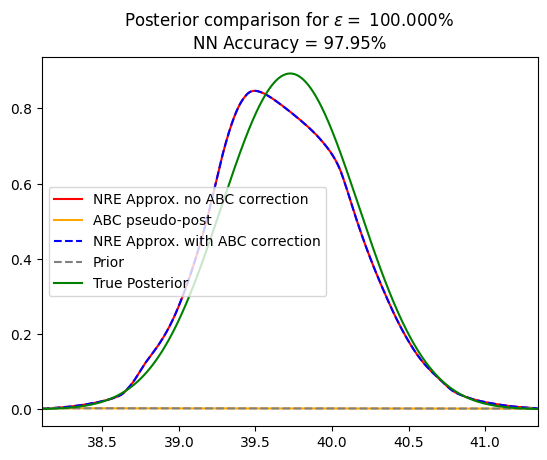

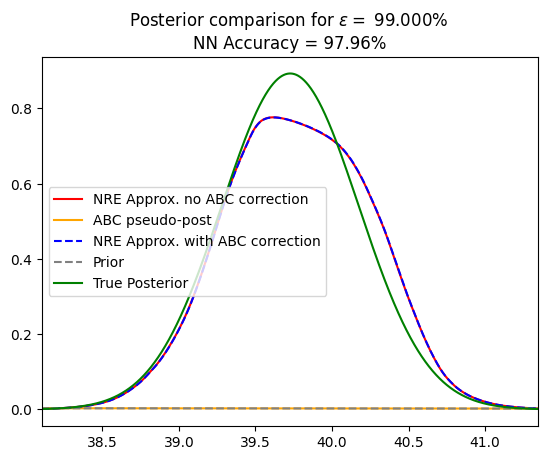

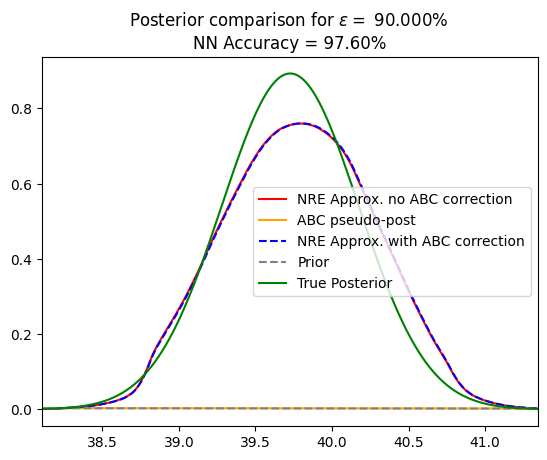

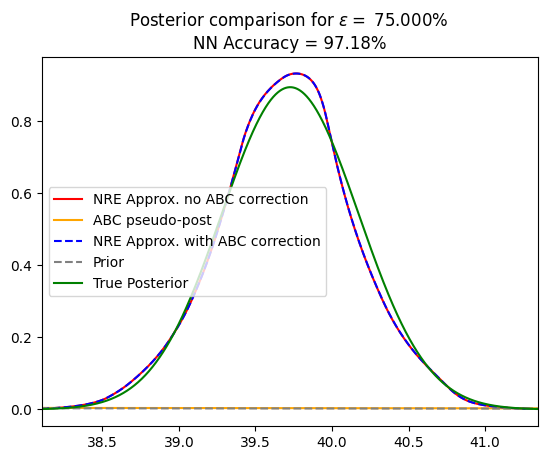

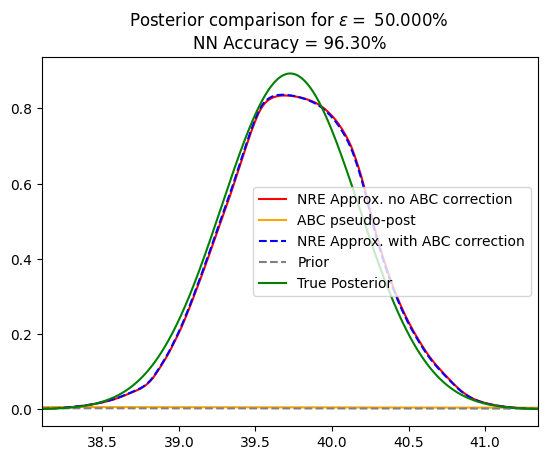

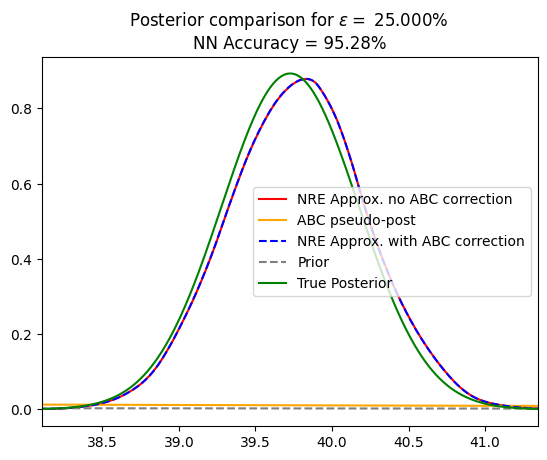

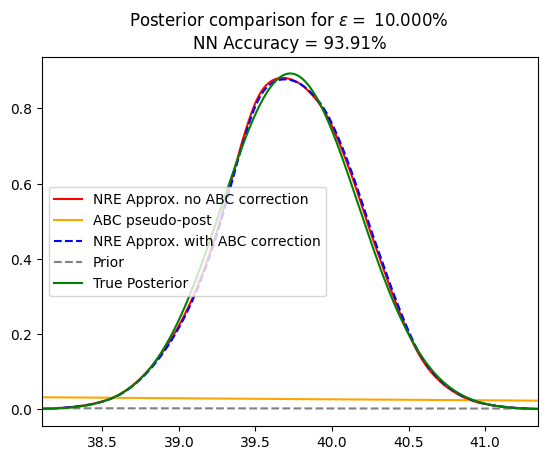

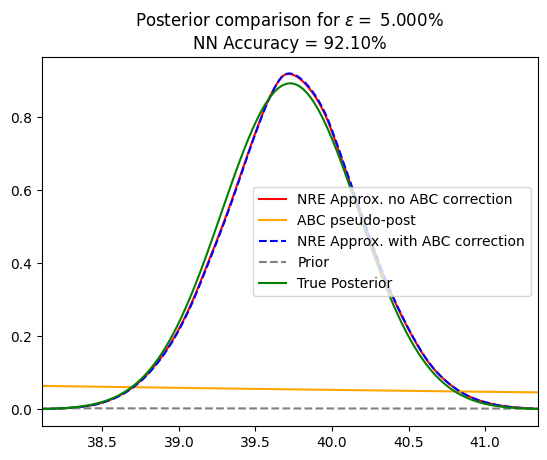

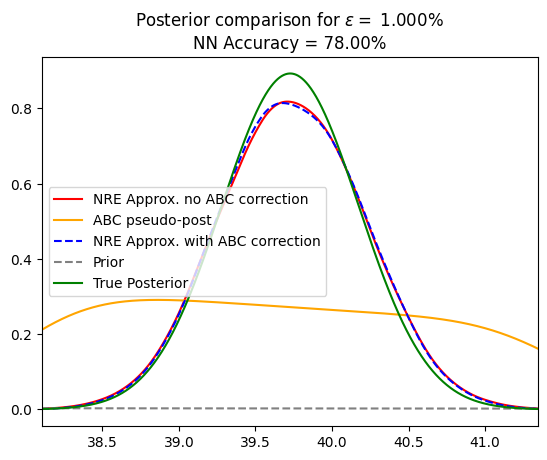

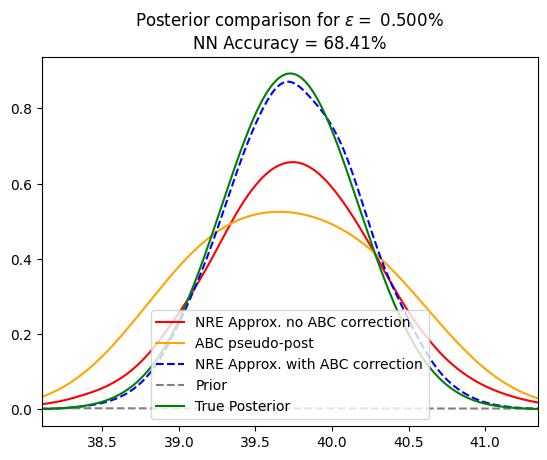

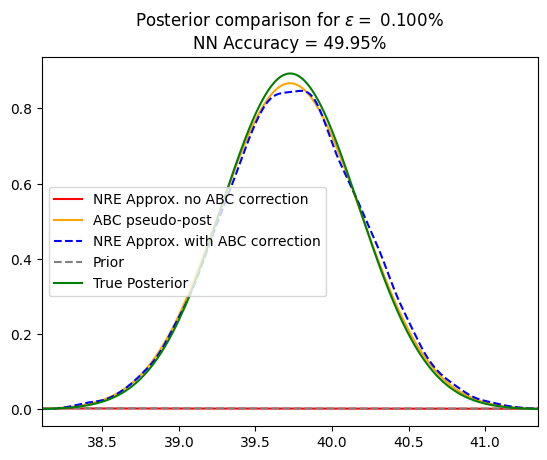

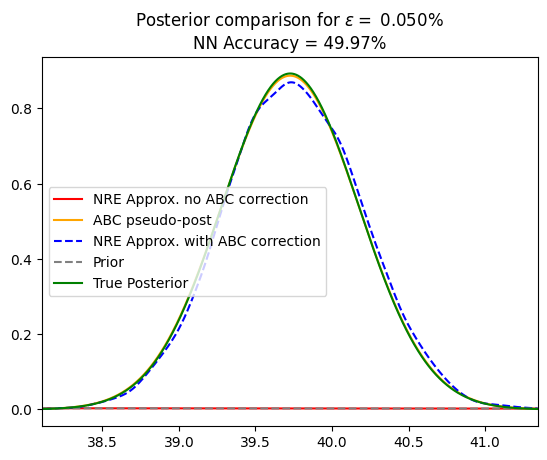

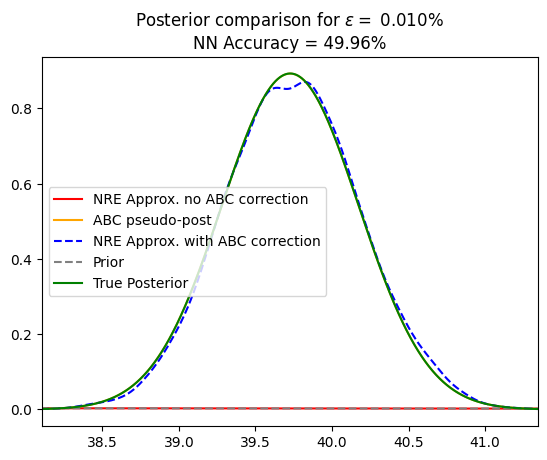

In [20]:


MIN_INIT, MAX_INIT = -100, 100
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
prior_pdf = lambda x: norm.pdf(x, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)
posterior = true_post
likelihood = lambda x: jnp.exp(jnp.sum((x-TRUE_DATA)**2)/(2*SIGMA**2))
grid_prior, pdf_prior = find_grid_explorative(prior_pdf, 10000, 10000, MIN_INIT, MAX_INIT)
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, MIN_INIT, MAX_INIT)

Z_prior = np.trapz(pdf_prior, grid_prior)
Z_true = np.trapz(pdf_true, grid_true)

for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    # kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior)
    kde_approx = gaussian_kde(THETAS_ABC[alpha])
    params = PARAMS[alpha] 
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior), 10000, 10000, MIN_INIT, MAX_INIT)
    
    grid_nre, pdf_nre = find_grid_explorative(lambda x:NRE_posterior_pdf(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MIN_INIT, MAX_INIT)
    
    grid_nre_corrected, pdf_nre_corrected = find_grid_explorative(lambda x: NRE_corrected_posterior_pdf(params, x, TRUE_DATA, kde_approx), 10000, 10000, MIN_INIT, MAX_INIT)
    
    Z_pseudo = np.trapz(pdf_pseudo, grid_pseudo)
    Z_nre = np.trapz(pdf_nre, grid_nre)
    Z_nre_corrected = np.trapz(pdf_nre_corrected, grid_nre_corrected)
    
    plt.plot(grid_nre, pdf_nre/Z_nre, label = 'NRE Approx. no ABC correction', color = "red")
    plt.plot(grid_pseudo, pdf_pseudo/Z_pseudo, label = "ABC pseudo-post", color = "orange")

    plt.plot(grid_nre_corrected, pdf_nre_corrected/Z_nre_corrected, label = "NRE Approx. with ABC correction", color = "blue", linestyle = "--")
    plt.plot(grid_prior, pdf_prior/Z_prior, label = 'Prior', color = "grey", linestyle = "--")
    plt.plot(grid_true, pdf_true/Z_true, label = 'True Posterior', color = "green")

    plt.xlim(np.min(grid_true), np.max(grid_true))
    plt.title(f"Posterior comparison for $\epsilon =$ {alpha:.3%} \nNN Accuracy = {TEST_ACCURACY[alpha]:.2%}")
    plt.legend()
    plt.show()
    df_figure = pd.DataFrame()
    df_figure["grid_nre"] = grid_nre
    df_figure["pdf_nre"] = pdf_nre
    df_figure["grid_pseudo"] = grid_pseudo
    df_figure["pdf_pseudo"] = pdf_pseudo
    df_figure["grid_nre_corrected"] = grid_nre_corrected
    df_figure["pdf_nre_corrected"] = pdf_nre_corrected
    df_figure["grid_prior"] = grid_prior
    df_figure["pdf_prior"] = pdf_prior
    df_figure["grid_true"] = grid_true
    df_figure["pdf_true"] = pdf_true

    df_figure.to_csv(PATH_RESULTS+f"/plot_posterior_comparison_{alpha}_{EPSILON_STAR:.3}.csv")
    

# Same figure from CSV

alpha =  1.0 epsilon =  inf


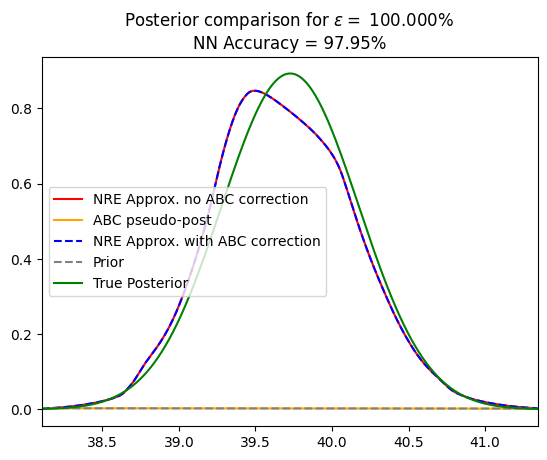

alpha =  0.99 epsilon =  7436.635


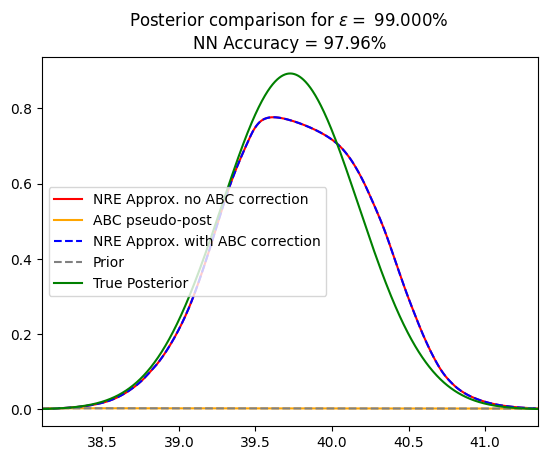

alpha =  0.9 epsilon =  4276.669


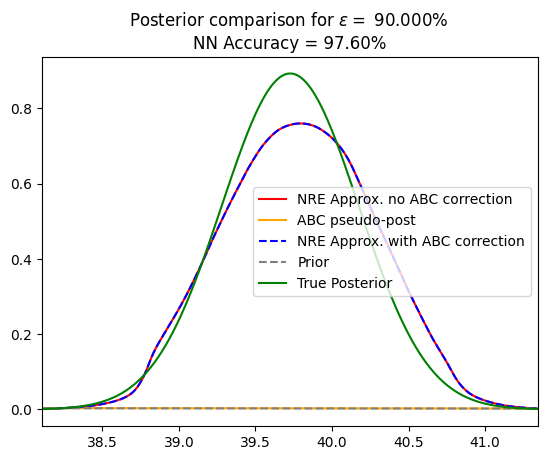

alpha =  0.75 epsilon =  2836.507


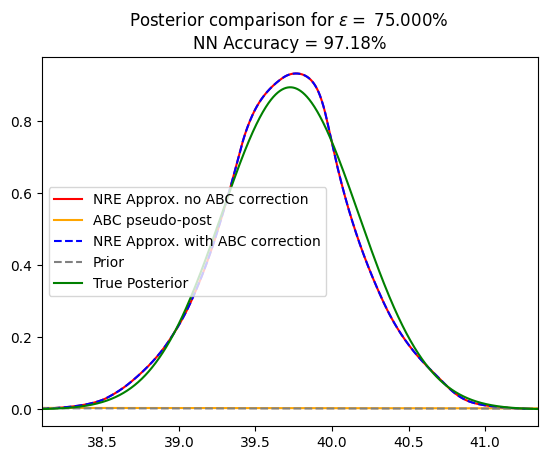

alpha =  0.5 epsilon =  1579.4377


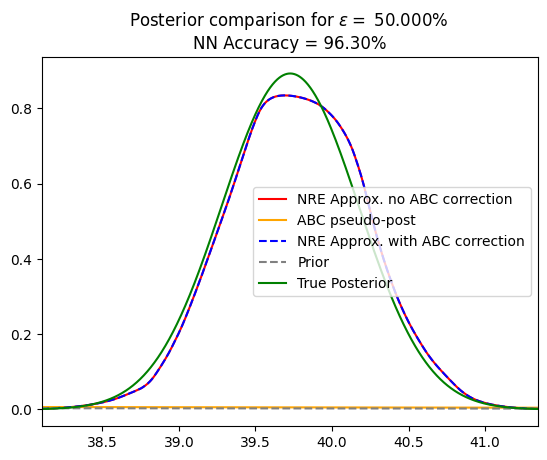

alpha =  0.25 epsilon =  690.6506


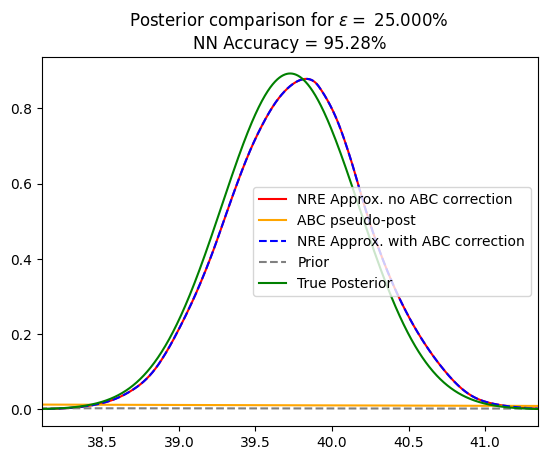

alpha =  0.1 epsilon =  210.05894


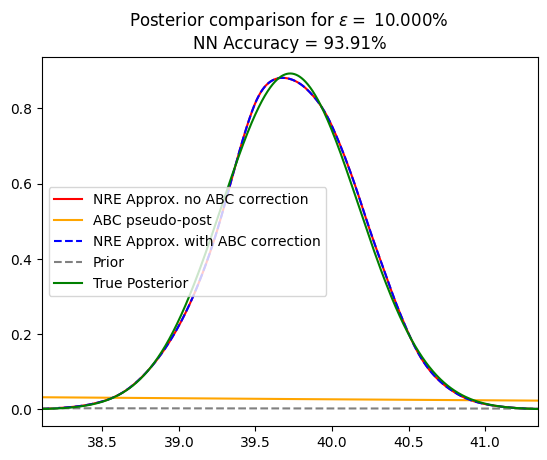

alpha =  0.05 epsilon =  70.14465


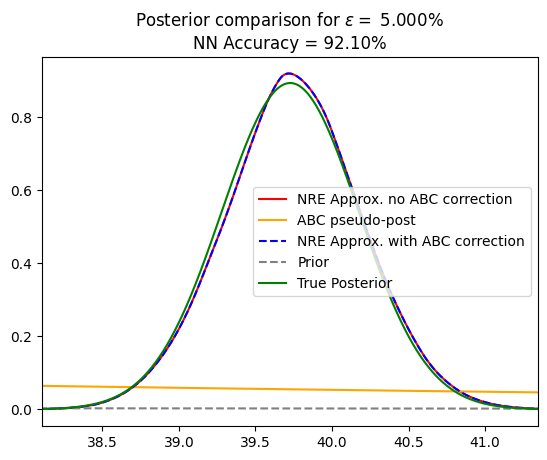

alpha =  0.01 epsilon =  3.3594604


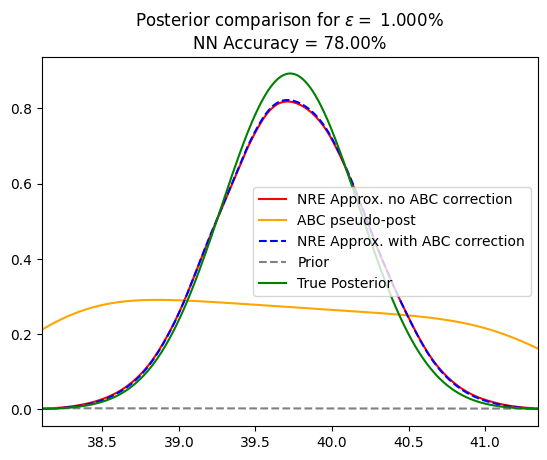

alpha =  0.005 epsilon =  0.8397964


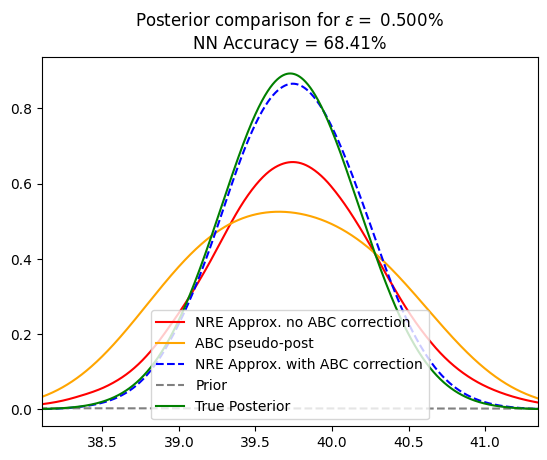

alpha =  0.001 epsilon =  0.035730872


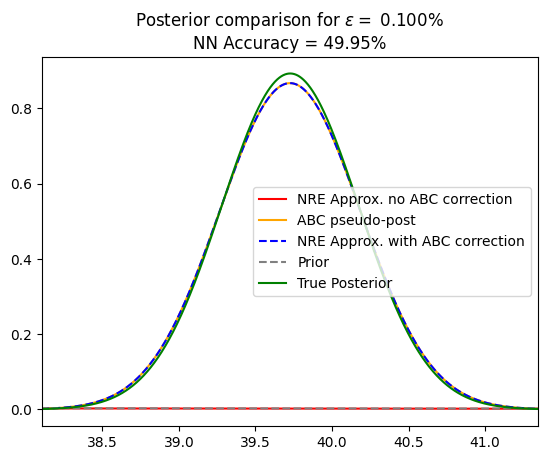

alpha =  0.0005 epsilon =  0.007935686


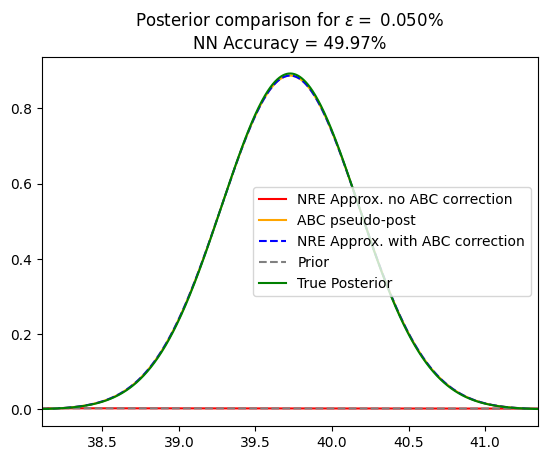

alpha =  0.0001 epsilon =  0.00035534802


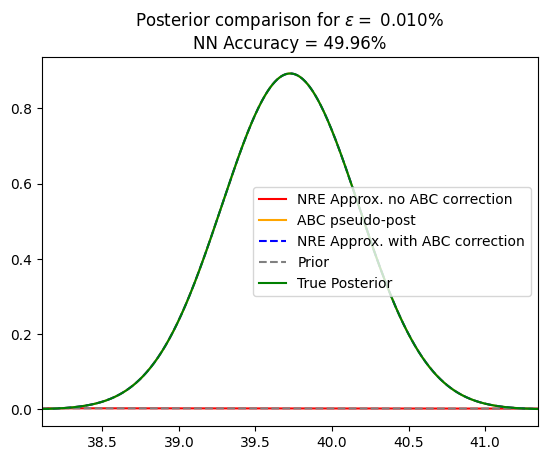

In [19]:
for alpha in ALPHAS: 
    EPSILON_STAR = EPSILONS[alpha]
    print("alpha = ", alpha, "epsilon = ", EPSILON_STAR)
    df_figure = pd.read_csv(PATH_RESULTS+f"/plot_posterior_comparison_{alpha}_{EPSILON_STAR:.3}.csv")
    grid_nre = df_figure["grid_nre"]
    pdf_nre = df_figure["pdf_nre"]
    grid_pseudo = df_figure["grid_pseudo"]
    pdf_pseudo = df_figure["pdf_pseudo"]
    grid_nre_corrected = df_figure["grid_nre_corrected"]
    pdf_nre_corrected = df_figure["pdf_nre_corrected"]
    grid_prior = df_figure["grid_prior"]
    pdf_prior = df_figure["pdf_prior"]
    grid_true = df_figure["grid_true"]
    pdf_true = df_figure["pdf_true"]
    
    Z_pseudo = np.trapz(pdf_pseudo, grid_pseudo)
    Z_nre = np.trapz(pdf_nre, grid_nre)
    Z_nre_corrected = np.trapz(pdf_nre_corrected, grid_nre_corrected)
    
    plt.plot(grid_nre, pdf_nre/Z_nre, label = 'NRE Approx. no ABC correction', color = "red")
    plt.plot(grid_pseudo, pdf_pseudo/Z_pseudo, label = "ABC pseudo-post", color = "orange")
    plt.plot(grid_nre_corrected, pdf_nre_corrected/Z_nre_corrected, label = "NRE Approx. with ABC correction", color = "blue", linestyle = "--")

    plt.plot(grid_prior, pdf_prior, label = 'Prior', color = "grey", linestyle = "--")
    plt.plot(grid_true, pdf_true, label = 'True Posterior', color = "green")
    plt.xlim(np.min(grid_true), np.max(grid_true))
    plt.title(f"Posterior comparison for $\epsilon =$ {alpha:.3%} \nNN Accuracy = {TEST_ACCURACY[alpha]:.2%}")
    plt.legend()
    plt.show()
    
    

## ABC Pseudo posterior

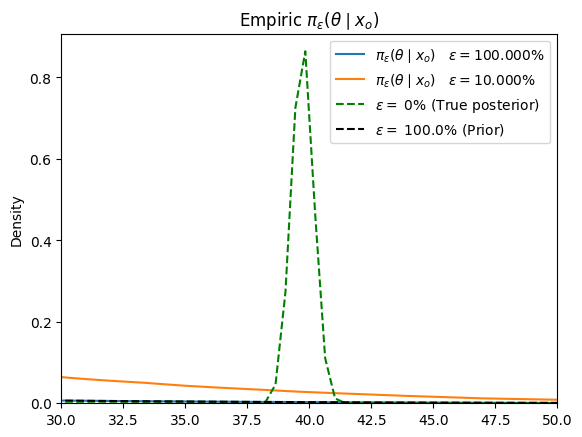

In [ ]:
for alpha in ALPHAS:
    zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, EPSILONS[alpha], 100000)
    label = "$\pi_\epsilon(\\theta\mid x_o) \quad \epsilon = ${:.3%}".format(alpha)
    sns.kdeplot(mus.reshape(-1), label = label)
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA).pdf(x), label = "$\epsilon =$ 0% (True posterior)", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "$\epsilon =$ 100.0% (Prior)", linestyle = "--", color = "black")
plt.title("Empiric $\pi_\epsilon(\\theta\mid x_o)$")
plt.legend()
plt.xlim(TRUE_MU-10, TRUE_MU+10)
plt.show()

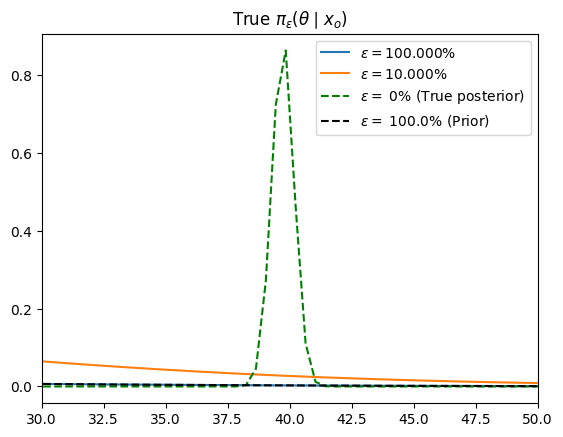

In [ ]:
prior = stats.norm(loc = MU0, scale = SIGMA0)
for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior), 1000, 1000, MIN_INIT, MAX_INIT)
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid_pseudo, pdf_pseudo/np.trapz(pdf_pseudo, grid_pseudo), label = label)
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA).pdf(x), label = "$\epsilon =$ 0% (True posterior)", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "$\epsilon =$ 100.0% (Prior)", linestyle = "--", color = "black")
plt.title("True $\pi_\epsilon(\\theta\mid x_o)$")
plt.legend()
plt.xlim(TRUE_MU-10, TRUE_MU+10)
plt.show()

## Decision function

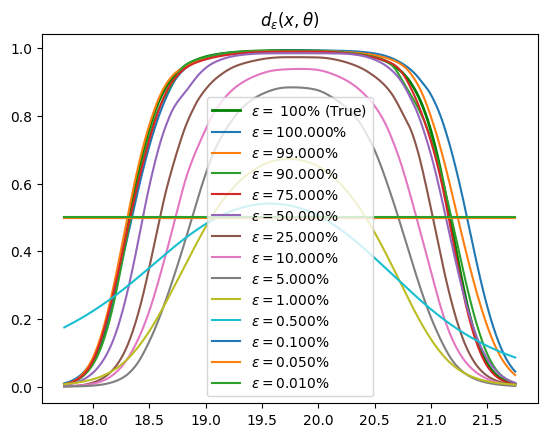

In [ ]:
grid = np.linspace(np.mean(TRUE_DATA)-2, np.mean(TRUE_DATA)+2, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
plt.plot(grid, true_decision, color = "green", label = "$\epsilon =$ 100% (True)", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_decision = 1/(1+jnp.exp(-logratio_batch_z(params, grid, TRUE_DATA)))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_decision, label = label)
plt.legend()
plt.title("$d_\epsilon(x,\\theta)$")
plt.show()



## Likelihood-to-evidence ratio

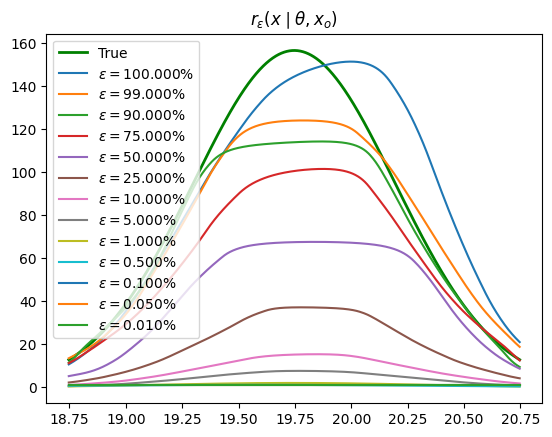

In [ ]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio, color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_ratio, label = label)
plt.legend()
plt.title("$r_\epsilon(x\mid \\theta, x_o)$")
plt.show()



## ABC-NRE approximation without correction and normalization

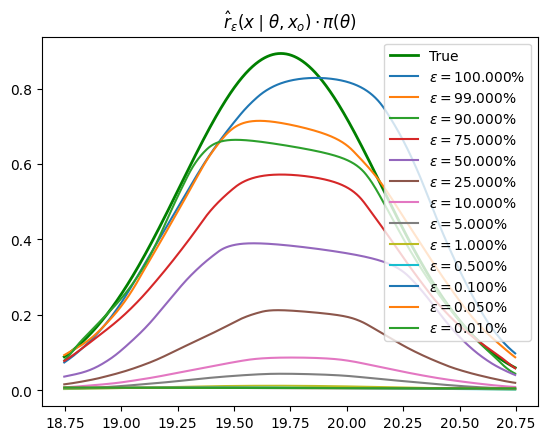

In [ ]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio*prior.pdf(grid), color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_ratio*prior.pdf(grid), label = label)
plt.legend()
plt.title("$\hat r_\epsilon(x\mid\\theta, x_o)\cdot \pi(\\theta)$")
plt.show()

## ABC-NRE approximation without correction but with normalization

Z_true = 0.974229990357939
Z_approx (for epsilon = inf) = 1.0
Z_approx (for epsilon = 1.8e+03) = 0.89
Z_approx (for epsilon = 1.1e+03) = 0.84
Z_approx (for epsilon = 7e+02) = 0.7
Z_approx (for epsilon = 3.9e+02) = 0.5
Z_approx (for epsilon = 1.7e+02) = 0.23
Z_approx (for epsilon = 5.1e+01) = 0.097
Z_approx (for epsilon = 1.7e+01) = 0.049
Z_approx (for epsilon = 0.79) = 0.015
Z_approx (for epsilon = 0.2) = 0.011
Z_approx (for epsilon = 0.0071) = 0.011
Z_approx (for epsilon = 0.0019) = 0.011
Z_approx (for epsilon = 7.6e-05) = 0.011


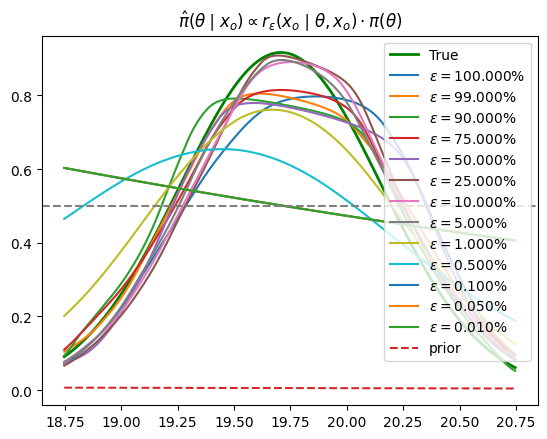

In [ ]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = prior.pdf(grid)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid,approx/Z_approx, label = label)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_o) \propto r_\epsilon(x_o\mid\\theta, x_o)\cdot \pi(\\theta)$")
plt.axhline(0.5, color = "grey", linestyle = "--")
plt.show()

## ABC-NRE approximation with correction but no normalization

/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_92108/1812100366.py:11: RuntimeWarning: divide by zero encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))
/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_92108/1812100366.py:11: RuntimeWarning: overflow encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))


(18.08180809020996, 21.32213020324707)

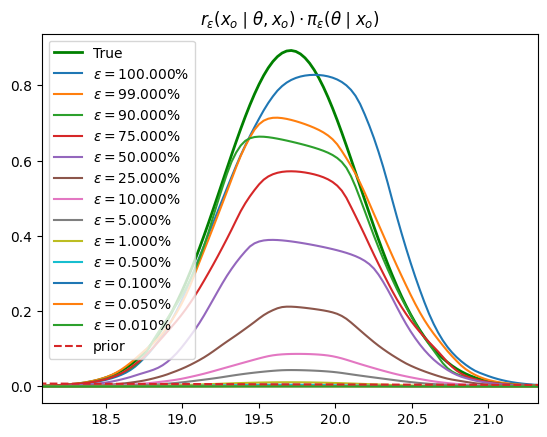

In [ ]:
grid = np.linspace(-100, 200, 10000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
plt.plot(grid,true_postt , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo#/np.trapz(pseudo, grid)
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid,approx, label = label)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")

plt.legend()
plt.title("$r_\epsilon(x_o\mid\\theta, x_o)\cdot \pi_\epsilon(\\theta\mid x_o)$")
plt.xlim(grid_true.min(), grid_true.max())

## ABC-NRE approximation with correction and normalization

Z_true = 0.974229990357939
Z_approx (for epsilon = inf) = 1.0
Z_approx (for epsilon = 1.8e+03) = 0.89
Z_approx (for epsilon = 1.1e+03) = 0.84
Z_approx (for epsilon = 7e+02) = 0.7
Z_approx (for epsilon = 3.9e+02) = 0.5
Z_approx (for epsilon = 1.7e+02) = 0.23
Z_approx (for epsilon = 5.1e+01) = 0.097
Z_approx (for epsilon = 1.7e+01) = 0.049
Z_approx (for epsilon = 0.79) = 0.013
Z_approx (for epsilon = 0.2) = 0.0049
Z_approx (for epsilon = 0.0071) = 0.00093
Z_approx (for epsilon = 0.0019) = 0.00048
Z_approx (for epsilon = 7.6e-05) = 9.7e-05


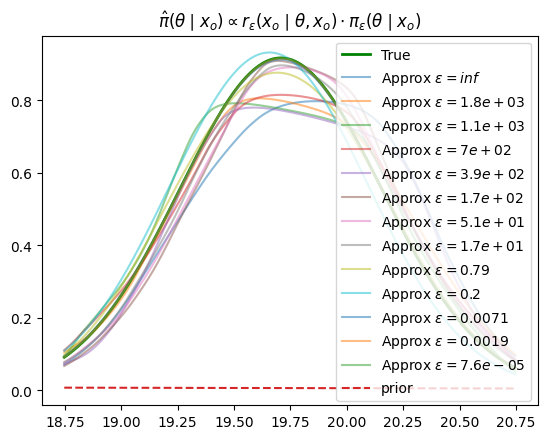

In [ ]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    plt.plot(grid,approx/Z_approx, label = f"Approx $\epsilon = {epsilon:.2}$", alpha = .5)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_o) \propto r_\epsilon(x_o\mid \\theta, x_o)\cdot \pi_\epsilon(\\theta\mid x_o)$")
plt.show()